In [1]:
import os
from glob import glob
import warnings
import json
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [4]:
hgtm_csv = '/home/meso/Insync/ondrive/sync/papers/hail-xsec_paper/hgtm-output/SimHailData.csv'
df = pd.read_csv(hgtm_csv)
print(df.keys())

Index(['dmax_mm', 'dry_growth_area_perc', 'final_wet_growth_area_perc',
       'dry_layer_count', 'largest_dry_area_perc'],
      dtype='object')


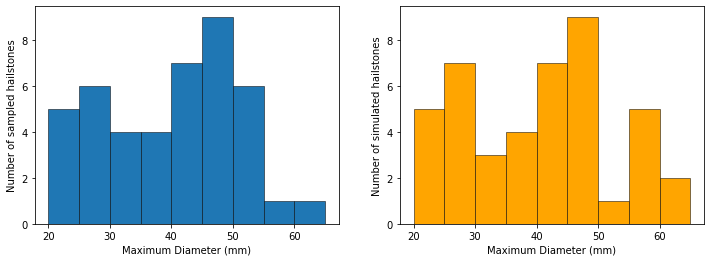

In [33]:
hgtm_size = df['dmax_mm']
obs_size = [48,54,60,57,53.4,48.6,46,45,51,53.5,48,41.5,43.8,51.3,45,51.5,48.3,23.5,44.7,38.5,40,42,28.5,21.1,35.1,27.5,26.4,31.6,30,44.26,30.7,29.65,47.25,35,26.8,24,40.3,36.6,45.13,33.4,25.66,23.8,23.5]

fig = plt.figure(figsize=[12,4], facecolor='w')
plt.subplot(121)
plt.hist(obs_size, bins=[20,25,30,35,40,45,50,55,60,65], edgecolor='black', linewidth=0.5)
plt.ylabel('Number of sampled hailstones')
plt.xlabel('Maximum Diameter (mm)')

plt.subplot(122)
plt.hist(hgtm_size, bins=[20,25,30,35,40,45,50,55,60,65], color='orange', edgecolor='black', linewidth=0.5)
plt.ylabel('Number of simulated hailstones')
plt.xlabel('Maximum Diameter (mm)')

plt.savefig('fig06.png', dpi=150)

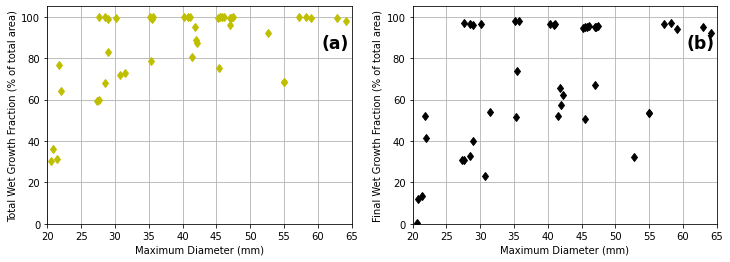

In [32]:
fig = plt.figure(figsize=[12,4], facecolor='w')

plt.subplot(121)
plt.plot(df['dmax_mm'], 100-(df['dry_growth_area_perc']), 'yd')
plt.xlabel('Maximum Diameter (mm)')
plt.ylabel('Total Wet Growth Fraction (% of total area)')
plt.xlim([20, 65])
plt.ylim([0, 105])
plt.grid()
plt.text(60.5, 85, '(a)', size='xx-large', weight='bold')

plt.subplot(122)
plt.plot(df['dmax_mm'], df['final_wet_growth_area_perc'], 'kd')
plt.xlabel('Maximum Diameter (mm)')
plt.ylabel('Final Wet Growth Fraction (% of total area)')
plt.xlim([20,65])
plt.ylim([0, 105])
plt.text(60.5, 85, '(b)', size='xx-large', weight='bold')
plt.grid()

plt.savefig('fig07.png', dpi=150)